In [1]:
import pandas as pd
import os

filepath = "../../datasets/ml-20m"

ratings = pd.read_csv(os.path.join(filepath, "ratings.csv"))
movies = pd.read_csv(os.path.join(filepath, "movies.csv"))
ratings = pd.merge(left=ratings, right=movies[["movieId", "title"]],on='movieId', how='left')
ratings.head()

,userId,movieId,rating,timestamp,title
0,1,2,3.5,1112486027,Jumanji (1995)
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p..."
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995)
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)"


In [2]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

# avoid unnecessarily big embedding size, by mathich it to the size of unique values
d = defaultdict(LabelEncoder)
cols_cat = ['userId', 'movieId']
for c in cols_cat:
    d[c].fit(ratings[c].unique())
    ratings[c] = d[c].transform(ratings[c])
    # to recover the original ids
    # d['userId'].inverse_transform(ratings['userId'])
ratings.head()

,userId,movieId,rating,timestamp,title
0,0,1,3.5,1112486027,Jumanji (1995)
1,0,28,3.5,1112484676,"City of Lost Children, The (Cité des enfants p..."
2,0,31,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
3,0,46,3.5,1112484727,Seven (a.k.a. Se7en) (1995)
4,0,49,3.5,1112484580,"Usual Suspects, The (1995)"


In [3]:
ratings.shape

(20000263, 5)

In [4]:
from torch.utils.data import DataLoader

# train matrix embbedings base on all user-item interactions except the last 5 interaction of each user
train_data = ratings.groupby("userId").head(-5).reset_index(drop=True)

# keep the last 5 interaction of a user as a holdout
houldout = ratings.groupby("userId").tail(10).reset_index(drop=True)
val_data = houldout.groupby("userId").head(5).reset_index(drop=True)
test_data = houldout.groupby("userId").tail(5).reset_index(drop=True)


print("train: ", train_data.shape)
print("val: ", val_data.shape)
print("test: ", test_data.shape)

train:  (19307798, 5)
val:  (692465, 5)
test:  (692465, 5)


In [5]:
from wmf import UserItemDataset

batch_size = 4096
train_dataset = UserItemDataset(data = train_data)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

val_dataset = UserItemDataset(data = val_data)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

test_dataset = UserItemDataset(data = test_data)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

next(iter(test_loader))

[tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4, 5, 5, 5, 5, 5, 6, 6]),
 tensor([7860, 7953, 8007, 8278, 9753, 3834, 3835, 3837, 3843, 3865, 2983, 2985,
         3011, 3055, 4964,  580,  583,  588,  590,  721, 1171, 1173, 1184, 1263,
         1362,  749,  767,  775,  789, 1052, 4867, 4897]),
 tensor([5.0000, 4.5000, 3.5000, 4.0000, 4.0000, 5.0000, 5.0000, 5.0000, 4.0000,
         5.0000, 4.0000, 4.0000, 4.0000, 4.0000, 5.0000, 4.0000, 4.0000, 4.0000,
         4.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 3.0000, 3.0000,
         4.0000, 3.0000, 1.0000, 5.0000, 4.0000], dtype=torch.float64)]

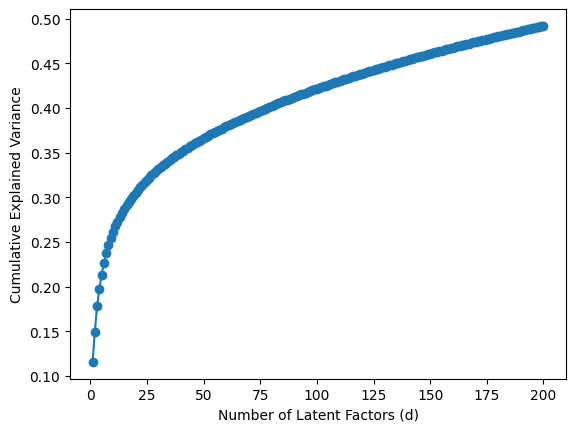

In [5]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# sparse_matrix[userId, movieId] = rating -> only it available, else 0
sparse_matrix = csr_matrix((ratings.rating, (ratings.userId, ratings.movieId)))

# randomized algorithm can process sparse data without ever needing the full
svd = TruncatedSVD(n_components=200, algorithm='randomized')
svd.fit(sparse_matrix)

plt.plot(range(1, 201), svd.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Latent Factors (d)')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [6]:
from wmf import WeightedMF

num_users = ratings["userId"].max()+1
num_items = ratings["movieId"].max()+1
num_factors = 25
device = "mps"

model = WeightedMF(num_users=num_users, num_items=num_items, num_factors=num_factors)
model.to(device)

WeightedMF(
  (user_embeddings): Embedding(138493, 25)
  (item_embeddings): Embedding(26744, 25)
)

In [7]:
import torch

user_ix, item_ix, _ = next(iter(train_loader))

with torch.no_grad():
    user_ix = user_ix.to(device)
    item_ix = item_ix.to(device)
    print(model(user_ix, item_ix))

tensor([ 4.7622e-05, -4.4957e-05, -1.0104e-04,  ..., -5.4352e-05,
         1.3167e-04,  2.4806e-04], device='mps:0')


In [8]:
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# define objective - MSE Loss
MSELoss = torch.nn.MSELoss(reduction = 'mean')
epochs = 10

train_loss_history = []
val_loss_history = []
for epoch in range(epochs):
    train_loss = 0
    nbatches = len(train_loader)
    for user_ix, item_ix, target in train_loader:
        user_ix = user_ix.to(device)
        item_ix = item_ix.to(device)
        target = target.to(device=device, dtype=torch.float32)
        
        predicted = model(user_ix, item_ix)
        loss = MSELoss(predicted, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    val_loss = 0
    for user_ix, item_ix, target in val_loader:
        with torch.no_grad():
            user_ix = user_ix.to(device)
            item_ix = item_ix.to(device)
            target = target.to(device=device, dtype=torch.float32)
            
            predicted = model(user_ix, item_ix)
            loss = MSELoss(predicted, target)
            val_loss += loss.item()
    
    train_loss_history.append(train_loss / len(train_loader))
    val_loss_history.append(val_loss / len(val_loader))
    print(f"[{epoch}/{epochs}] Train Loss: {train_loss_history[-1]:.6f} Val Loss: {val_loss_history[-1]:.6f}")




[0/10] Train Loss: 2.356147 Val Loss: 0.965047
[1/10] Train Loss: 0.784176 Val Loss: 0.863690
[2/10] Train Loss: 0.736063 Val Loss: 0.814348
[3/10] Train Loss: 0.701559 Val Loss: 0.772768
[4/10] Train Loss: 0.666361 Val Loss: 0.724028
[5/10] Train Loss: 0.632237 Val Loss: 0.672655
[6/10] Train Loss: 0.600712 Val Loss: 0.623639
[7/10] Train Loss: 0.572873 Val Loss: 0.577820
[8/10] Train Loss: 0.548860 Val Loss: 0.535550
[9/10] Train Loss: 0.529337 Val Loss: 0.500201


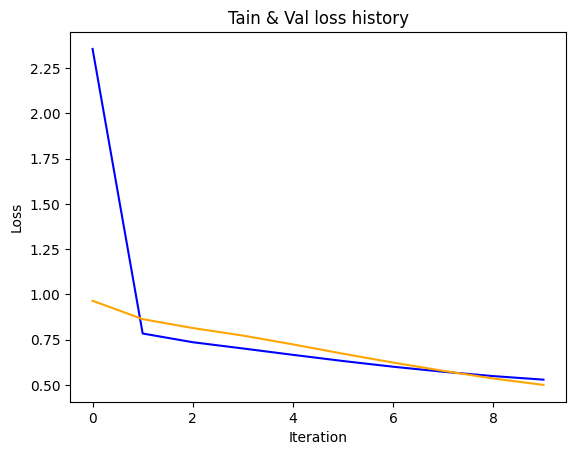

In [9]:
import matplotlib.pyplot as plt

# Plot the training losses.
plt.plot(train_loss_history, color='blue', label='Train')
plt.plot(val_loss_history, color='orange', label='Val')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Tain & Val loss history')
plt.show()

In [26]:
test_user_ix, test_item_ix, _ = next(iter(test_loader))
test_user_ix = test_user_ix
test_item_ix = test_item_ix
model.to("cpu")
with torch.no_grad():
    test_sample = test_data.iloc[:32]
    test_sample["predicted"] = model(test_user_ix, test_item_ix).tolist()

/var/folders/p7/0mtps3dx0j53wy850n_xxltr0000gn/T/ipykernel_92150/618208401.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample["predicted"] = model(test_user_ix, test_item_ix).tolist()


In [27]:
test_sample

,userId,movieId,rating,timestamp,title,predicted
0,0,7860,5.0,1094786027,Freaks (1932),3.279632
1,0,7953,4.5,1112485493,Spider-Man 2 (2004),3.967050
2,0,8007,3.5,1112484795,Slaughterhouse-Five (1972),3.765459
3,0,8278,4.0,1112485629,"Incredibles, The (2004)",3.879449
4,0,9753,4.0,1112485748,Constantine (2005),4.027020
5,1,3834,5.0,974820748,Fantastic Voyage (1966),3.859724
6,1,3835,5.0,974820776,Abbott and Costello Meet Frankenstein (1948),3.511333
7,1,3837,5.0,974820943,"Creature from the Black Lagoon, The (1954)",3.236800
8,1,3843,4.0,974820916,Runaway (1984),3.318891
9,1,3865,5.0,974820659,"Time Machine, The (1960)",4.106062


In [6]:
# now lets say we did not have explicit ratings, lets represent all interactions as positive implicit data
# watched - 1, not watched - 0
# training can be easily dominated by 0s, so we can adjust by adding additional weight

train_data["rating"] = 1
val_data["rating"] = 1
test_data["rating"] = 1
test_data.head()

,userId,movieId,rating,timestamp,title
0,0,7860,1,1094786027,Freaks (1932)
1,0,7953,1,1112485493,Spider-Man 2 (2004)
2,0,8007,1,1112484795,Slaughterhouse-Five (1972)
3,0,8278,1,1112485629,"Incredibles, The (2004)"
4,0,9753,1,1112485748,Constantine (2005)


In [10]:
from wmf import UserItemDatasetSparse

pos_prob = 0.1

train_dataset = UserItemDatasetSparse(data = train_data, p = pos_prob)
train_loader = DataLoader(dataset=train_dataset, batch_size=4096, shuffle=True, num_workers=8)

val_dataset = UserItemDatasetSparse(data = val_data, p = pos_prob)
val_loader = DataLoader(dataset=val_dataset, batch_size=4096, shuffle=True, num_workers=8)

test_dataset = UserItemDatasetSparse(data = test_data, p = pos_prob)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

next(iter(train_loader))

[tensor([  7762, 125700,  82021,  ...,  14416,   1812,  11054]),
 tensor([ 3609,  1204, 18753,  ...,  8931,  5690, 25479]),
 tensor([0, 0, 0,  ..., 0, 0, 0])]

In [8]:
import torch
from wmf import WeightedMF

num_users = ratings["userId"].max()+1
num_items = ratings["movieId"].max()+1
num_factors = 25
device = "mps"

model = WeightedMF(num_users=num_users, num_items=num_items, num_factors=num_factors)
model.to(device)


# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# LR = 0.2
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# define objective - MSE Loss
MSELoss = torch.nn.MSELoss(reduction = 'none')
WEIGHT = 40 # hyperparameter to force bigger gradients for positive samples
EPOCHS = 40

train_loss_history = []
val_loss_history = []

print("validation loss is not a weighted loss since we do not care about gradients")
for epoch in range(EPOCHS):
    train_loss = 0
    nbatches = len(train_loader)
    for user_ix, item_ix, target in train_loader:
        user_ix = user_ix.to(device)
        item_ix = item_ix.to(device)
        target = target.to(device=device, dtype=torch.float32)
        
        predicted = model(user_ix, item_ix)
        loss = MSELoss(predicted, target)
        weight_vector = torch.ones_like(loss)
        weight_vector[target > 0] += WEIGHT-1
        loss = torch.mean((weight_vector * loss))

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    val_loss = 0
    for user_ix, item_ix, target in val_loader:
        with torch.no_grad():
            user_ix = user_ix.to(device)
            item_ix = item_ix.to(device)
            target = target.to(device=device, dtype=torch.float32)
            
            predicted = model(user_ix, item_ix)
            loss = torch.mean(MSELoss(predicted, target))
            val_loss += loss.item()
    
    train_loss_history.append(train_loss / len(train_loader))
    val_loss_history.append(val_loss / len(val_loader))
    print(f"[{epoch}/{EPOCHS}] Train Loss: {train_loss_history[-1]:.6f} Val Loss: {val_loss_history[-1]:.6f}")



validation loss is not a weighted loss since we do not care about gradients
[0/40] Train Loss: 1.399866 Val Loss: 0.124553
[1/40] Train Loss: 0.310593 Val Loss: 0.138232
[2/40] Train Loss: 0.279331 Val Loss: 0.131547
[3/40] Train Loss: 0.264179 Val Loss: 0.120925
[4/40] Train Loss: 0.247043 Val Loss: 0.110495
[5/40] Train Loss: 0.232898 Val Loss: 0.102234
[6/40] Train Loss: 0.221397 Val Loss: 0.095820
[7/40] Train Loss: 0.212314 Val Loss: 0.092106
[8/40] Train Loss: 0.204854 Val Loss: 0.088255
[9/40] Train Loss: 0.198876 Val Loss: 0.086199
[10/40] Train Loss: 0.193920 Val Loss: 0.083614
[11/40] Train Loss: 0.189632 Val Loss: 0.082607
[12/40] Train Loss: 0.186255 Val Loss: 0.080639
[13/40] Train Loss: 0.183402 Val Loss: 0.079725
[14/40] Train Loss: 0.181004 Val Loss: 0.078391
[15/40] Train Loss: 0.178623 Val Loss: 0.078077
[16/40] Train Loss: 0.176997 Val Loss: 0.077009
[17/40] Train Loss: 0.175498 Val Loss: 0.077246
[18/40] Train Loss: 0.174238 Val Loss: 0.076393
[19/40] Train Loss: 0.

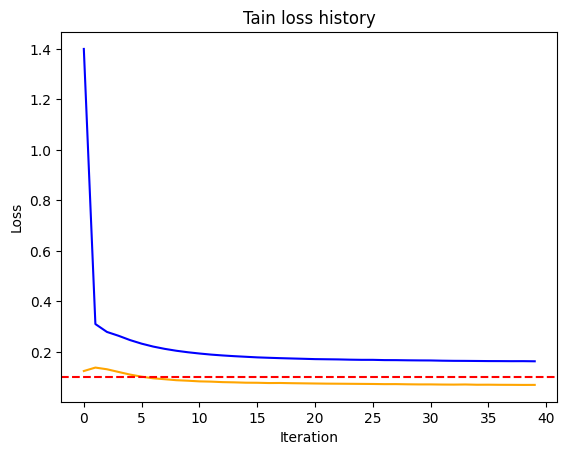

In [11]:
import matplotlib.pyplot as plt

# Plot the training losses.
plt.plot(train_loss_history, color='blue', label='Train')
plt.plot(val_loss_history, color='orange', label='Val')

# Add a horizontal line for the naive baseline
plt.axhline(y=pos_prob, color='red', linestyle='--', label='Baseline (Val)')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Tain loss history')
plt.show()

In [12]:
# could modify the Dataset class to pick positive samples with certain probability, so it always has some percentage of positive samples in a batch
test_user_ix, test_item_ix, _ = next(iter(test_loader))
test_user_ix = test_user_ix
test_item_ix = test_item_ix
model.to("cpu")
with torch.no_grad():
    test_sample = test_data.iloc[:32]
    test_sample["predicted"] = model(test_user_ix, test_item_ix).tolist()

/var/folders/p7/0mtps3dx0j53wy850n_xxltr0000gn/T/ipykernel_3011/669066974.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample["predicted"] = model(test_user_ix, test_item_ix).tolist()


In [13]:
test_sample

,userId,movieId,rating,timestamp,title,predicted
0,0,7860,1,1094786027,Freaks (1932),0.734118
1,0,7953,1,1112485493,Spider-Man 2 (2004),0.977311
2,0,8007,1,1112484795,Slaughterhouse-Five (1972),0.020725
3,0,8278,1,1112485629,"Incredibles, The (2004)",-0.088175
4,0,9753,1,1112485748,Constantine (2005),-0.003532
5,1,3834,1,974820748,Fantastic Voyage (1966),0.631438
6,1,3835,1,974820776,Abbott and Costello Meet Frankenstein (1948),0.816491
7,1,3837,1,974820943,"Creature from the Black Lagoon, The (1954)",0.020682
8,1,3843,1,974820916,Runaway (1984),0.323840
9,1,3865,1,974820659,"Time Machine, The (1960)",-0.052956
